# Lab 2
by Domrachev Ivan, B20-RO-01

In [1]:
import numpy as np
import pandas as pd 
import torch 
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm 
import warnings
warnings.filterwarnings("ignore")

from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

2023-09-10 14:53:26.139014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 14:53:27.557772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#  Step 1. Data loading & preprocessing

In [2]:
train_df = pd.read_csv('data/mnist_train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# split images and labels
labels = train_df[0].values
images = train_df.drop(0, axis=1).values.reshape(-1, 28, 28) / 255

In [4]:
# Preprocess images
transform = transforms.Compose(
    [
        #   Here you can add more augmentations.
        #   See documentation: https://pytorch.org/vision/stable/transforms.html
        transforms.ToTensor()
    ]
)

In [5]:
# convert data to tensors
images_t = torch.stack([transform(image).float() for image in images])
labels_t = torch.from_numpy(labels)
images_t.shape, labels_t.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [6]:
import matplotlib.pyplot as plt


def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()


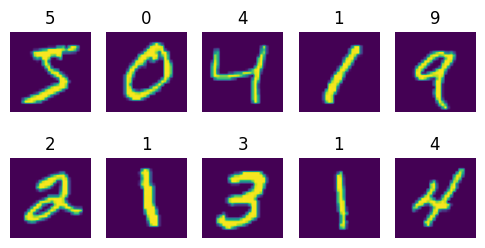

In [7]:
# Visualise 10 images from the dataset
plot_images(images[:10], labels[:10])


# Part 2. Train-test split

In [43]:
processed_dataset = TensorDataset(images_t, labels_t)

# set proportion and split dataset into train and validation parts
proportion = [0.95, 0.05]
train_dataset, val_dataset = random_split(processed_dataset, lengths=proportion)

In [44]:
# Create Dataloaders for training
# Dataloader is iterable object over dataset
batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Part 3. The model

The considered class of models is NN one. 

In [45]:
class ClassificationModel(nn.Module):
    """
    MLP (multi-layer perceptron) based classification model for MNIST
    """

    def __init__(self, num_classes=10):
        super(ClassificationModel, self).__init__()

        # Add fully connected layers to nn.Sequential to create MLP
        # First layer should take 28x28 vector
        # last layer should return vector of size num_classes
        # do not forget to add activation function between layers

        self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)

# Part 4. Training

In [46]:
device    = 'cuda' if torch.cuda.is_available else 'cpu'
model     = ClassificationModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
writer    = SummaryWriter()
model

ClassificationModel(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)

In [47]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    writer,
    epochs=1,
    device="cpu",
    ckpt_path="data/best.pt",
):
    # best score for checkpointing
    best = 0.0
    
    # iterating over epochs
    for epoch in range(epochs):
        # # training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        model.train()
        train_loss = 0.0
        # iterate over dataset 
        for i, data in train_loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass and loss calculation
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # backward pass
            loss.backward()

            # optimizer run
            optimizer.step()

            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})

        # write loss to tensorboard
        writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)
        
        # validation
        correct = 0
        total = 0
        with torch.no_grad():
            model.eval()  # evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for i, data in val_loop:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                predicted = torch.argmax(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).type(torch.FloatTensor).sum()

                val_loop.set_postfix({"acc": correct / total})

            if correct / total > best:
                torch.save(model.state_dict(), ckpt_path)
                best = correct / total


In [48]:
train(
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    writer=writer,
    epochs = 30
)

Epoch 0:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/285 [00:00<?, ?it/s]

Val:   0%|          | 0/15 [00:00<?, ?it/s]

In [49]:
#!tensorboard --logdir . 

# Part 5. Generate predictions

In [50]:
# load best checkpoint to model
model = ClassificationModel()
ckpt = torch.load("data/best.pt")
model.load_state_dict(ckpt)
model.to(device)

ClassificationModel(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)

In [51]:
def predict(model, test_loader, device):
    """
    Run model inference on test data
    """
    predictions = []
    with torch.no_grad():
        model.eval()  # evaluation mode
        test_loop = tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="Test")
        for i, inputs in test_loop:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            predictions.extend(predicted.tolist())
        return predictions


In [52]:
# read test data
test_df = pd.read_csv('data/mnist_test.csv', header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# process test data and run inference on it
images = test_df.values.reshape(-1,28, 28)/255
images = torch.stack([transform(image).float() for image in images])
test_loader = DataLoader(images)
predictions = predict(model, test_loader, device=device)

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
# generate the submission file
submission_df = pd.DataFrame(columns=['id', 'label'])
submission_df['id'] = test_df.index
submission_df['label'] = predictions
submission_df.to_csv('data/submission.csv', index=None)